# BPE (Byte Pair Encoding)
In this jupyter notebook we are going to walk through the Byte Pair Encoding tokenization algorithm. Byte Pair Encoding is the first of several subword tokenization algorithms. At a very high level it works in 3 steps
1. Compute the frequency of all token pairings
2. Choose the most frequent token pairing (t1, t2)
3. Merge t1 and t2, treating them as a single token within our vocabulary

Read the original paper: [this paper](https://arxiv.org/pdf/1508.07909.pdf)

## Definition
Note that throughout this document I will use the following terms
- **Corpus** 
    - a raw unformatted text blob
    - eg. 
    ```
    "CHAPTER I
        "Well, Prince, so Genoa and Lucca are now just family estates of the
        Buonapartes. But I warn you, if you don't tell me that this means war,
        if you still try to defend the infamies and horrors perpetrated by that
        Antichrist--I really believe he is Antichrist--I will have nothing more
        to do with you and you are no longer my friend, no longer my 'faithful
        slave,' as you call yourself! But how do you do? I see I have frightened
        you--sit down and tell me all the news."
    ```
- **Document** 
    - a list of strings (input to BPE)
    - eg. 
    ```python
    ['"Well, Prince, so Genoa and Lucca are now just family estates of the',
     "Buonapartes. But I warn you, if you don't tell me that this means war,",
     'if you still try to defend the infamies and horrors perpetrated by that',
     'Antichrist--I really believe he is Antichrist--I will have nothing more',
     "to do with you and you are no longer my friend, no longer my 'faithful",
     "slave,' as you call yourself! But how do you do? I see I have frightened",
     'you--sit down and tell me all the news."']
    ```
- **Vocabulary**
    - a dictionary which holds our set of tokens and their frequencies
    - eg
       ```bash
            a n d </w> : 34
            t h e </w> : 29
            a </w> : 29
        ```
- **Token** 
    - an element in our vocabulary.
    - eg. if our vocabulary is
        ```bash
            a n d </w> : 34
            t h e </w> : 29
            a </w> : 29
        ```
    then our tokens are
        ```bash
            a n d </w>
            t h e </w>
            a </w>
        ```
    
- **Character** 
    - a single element in a string "a" is a character "at" is not a character
    - eg if the input strings are
    ```
        "abc"
    ```
    - then the characters are
    ```
        "a", "b", "c"
    ```

In [1]:
import os, random, re, json, string
from pathlib import Path
from collections import defaultdict

import matplotlib.pyplot as plt

## Dataset

To demonstrate how this tokenization algorithm works we first need a sample corpus. I pulled War and Peace as a raw text file from [here](https://raw.githubusercontent.com/mmcky/nyu-econ-370/master/notebooks/data/book-war-and-peace.txt), and I've implemented several simple rules to ensure that the the sample sentences which we pull are interesting

In [2]:
def get_example_document(corpus):
    """ returns list of strings (sentences from war and peace) """
    example_sentences = []
    MIN_NUM_CHARACTERS, SAMPLE_PROB, CAPACITY = 5, .1, 50
    with open(corpus, "r") as f:
        for sentence in f.readlines():
            # strip whitespace, remove all new lines
            sentence = sentence.strip().replace("\n", "").lower()
            sentence = sentence.translate(str.maketrans('', '', string.punctuation))
            # all sentences myst have at least 
            # {MIN_NUM_CHARACTERS}
            if len(sentence) > MIN_NUM_CHARACTERS:
                
                # sample sentences with probability
                # {SAMPLE_PROB}
                if random.random() < SAMPLE_PROB:
                    example_sentences.append(sentence)
            
            # we never want to sample more than
            # {CAPACITY} sentences from our corpus
            if len(example_sentences) >= CAPACITY:
                break
    return example_sentences

In [3]:
corpus = os.path.join(Path(os.getcwd()).parent.parent, "Datasets", "war_and_peace.txt")

In [4]:
example_document = get_example_document(corpus)

## Implementation

In [5]:
# utility functions

def print_helper(vocab, N):
    """prints the top {N} tokens and their counts in the given vocabulary"""
    sorted_by_count = sorted(list(vocab.items()), key=lambda x: x[1], reverse=True)[:N]
    for key, val in sorted_by_count:
        print("{} : {}".format(key, val))
    
    if N > len(vocab):
        print("\tetc...")
        
def get_tokens(vocab):
    """
    input:
        eg. {}
    """
    tokens = defaultdict(int)
    vocab_tokenization = {}
    for word, freq in vocab.items():
        word_tokens = word.split()
        for token in word_tokens:
            tokens[token] += freq
        vocab_tokenization[''.join(word_tokens)] = word_tokens
    return tokens, vocab_tokenization

def measure_token_length(token):
    if token[-4:] == '</w>':
        return len(token[:-4]) + 1
    else:
        return len(token)

### Step 1) Generate Vocabulary

In [6]:
def get_vocab(document):
    """
    split every element in the document
    by whitespace " "
        eg. "the cat in the hat" -> [the, cat, in, the, hat]
    
    split each word into a list of characters,
    add a whitespace on the end, and the string '</w>'
    to denote the end of a word 
        eg [the, cat, in, the, hat] -> ['t h e </w>', 'c a t </w>', 'i n </w>', 'h a t </w>']
    """
    vocab = defaultdict(int)
    for sentence in document:
        word_tokens = sentence.strip().split()
        for token in word_tokens:
            vocab[' '.join(list(token)) + ' </w>'] += 1

    return vocab

In [7]:
starting_vocab = get_vocab(example_document)
print_helper(starting_vocab, 10)

t h e </w> : 26
a n d </w> : 15
o f </w> : 15
t o </w> : 12
a </w> : 12
i n </w> : 11
t h a t </w> : 9
i </w> : 8
y o u </w> : 8
a n n a </w> : 8


### Step 2) Count Character Pairings

In [8]:
def most_frequent_token_pairs(vocab):
    """
    iterate through vocab tokens character by character
    finding the most common adjacencies
    
    eg.
        vocab = {'c a t </w>' : 10, 'h a t </w>' : 2}
    
        most_frequent_token_pairs(vocab) = 
            {('c', 'a'): 10, ('a', 't'): 12, ('t', '</w>'): 12, ('h', 'a'): 2})
            
    note that the frequencies of given tokens are added onto the pairs
    """
    pairs = defaultdict(int)
    for token, freq in vocab.items():
        characters = token.split()
        for i in range(len(characters)-1):
            pairs[characters[i],characters[i+1]] += freq
    return pairs

In [9]:
starting_vocab = get_vocab(example_document)
character_pair_frequency = most_frequent_token_pairs(starting_vocab)
print_helper(character_pair_frequency, 10)

('e', '</w>') : 104
('d', '</w>') : 71
('t', 'h') : 64
('h', 'e') : 62
('t', '</w>') : 48
('i', 'n') : 47
('e', 'r') : 45
('s', '</w>') : 43
('h', 'a') : 39
('a', 'n') : 38


### Step 3) Merging Vocab

In [10]:
def merge_vocab(pair, v_in):
    """
    BPE starts by represents all characters in a word as
    standalone characters (note how they are delimited by 
    spaces)
    
    eg. t h e </w>
    
    if we had an input pair (e, </w>), meaning that the two
    characters which most often follower each other were "e"
    followed by the endword token "</w>" then we would want 
    to merge these two tokens into one single token "e</w>"
    
    eg. t h e </w> -(merge operation)-> t h e</w>
    """
    v_out = {}
    bigram = re.escape(' '.join(pair))
    p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
    for word in v_in:
        w_out = p.sub(''.join(pair), word)
        v_out[w_out] = v_in[word]
    return v_out

In [11]:
pair, count = max(character_pair_frequency.items(), key=lambda x: x[1])
new_vocab = merge_vocab(pair, starting_vocab)
print_helper(new_vocab, 10)

t h e</w> : 26
a n d </w> : 15
o f </w> : 15
t o </w> : 12
a </w> : 12
i n </w> : 11
t h a t </w> : 9
i </w> : 8
y o u </w> : 8
a n n a </w> : 8


### Putting it all Together

In [12]:
def bpe(vocab, num_merges):
    """ putting together all the steps to create BPE"""
    most_common_pairings = []
    vocab_lengths = []
    
    for _ in range(num_merges):
        
        # 1.Compute the frequency of all token pairings
        token_pairings = most_frequent_token_pairs(vocab)
        
        # edge case:
        #   if there is no whitespaces in the tokens,
        #   most_frequent_token_pairs returns an empty dict
        if token_pairings:
            # 2. Choose the most frequent token pairing (t1, t2)
            most_common_pairing, _ = max(token_pairings.items(), key=lambda x: x[1])
            most_common_pairings.append(most_common_pairing)

            # 3. Merge t1 and t2, treating them as a single token within our vocabulary
            vocab = merge_vocab(most_common_pairing, vocab)
            tokens, _ = get_tokens(vocab)
            vocab_lengths.append(len(tokens))
        else:
            break
    
    return vocab, most_common_pairings, vocab_lengths  

In [28]:
initial_vocab = get_vocab(example_document)
final_vocab, most_common_pairings, vocab_lengths = bpe(initial_vocab, 500)

### BPE Performance
How do we expect BPE to perform? We know that the intial vocab size is going to increase as we merge unigrams into bigrams (there are going to be more unigrams than bigrams). We also expect that after a certain number of merges our vocab will decrease as n-grams become words

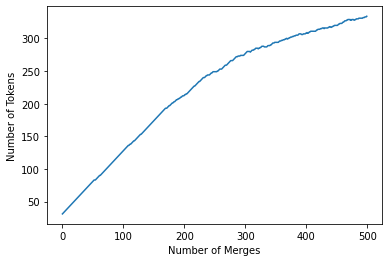

In [29]:
plt.xlabel("Number of Merges")
plt.ylabel("Number of Tokens")
plt.plot(range(len(vocab_lengths)), vocab_lengths)

### Encoding and Decoding
Once we have determined our subword pairings
- how do we encode sentences?
- how do we decode encoded sentences?
- what do we tokenize first?

### Encoding Sentences
Encoding Sentenes is fairly tricky. BPE is a greedy algorithm, meaning the first tokens we encode are the most frequent tokens. The code works out roughly to 
- split the sentence into a list of words
    - replace subword tokens within word until 
        - either we have traverse the full vocabulary
        - or the word is full tokenized
    - if there are any characters at the end which are not recognized as tokens, replace them with "\<u\>" or "unknown token"

In [15]:
def subword_encode(word, sorted_tokens):
    """ wrap all subword tokens with || and unkown tokens with <u>"""   
    word = re.escape(word)
    for token in sorted_tokens:
        
        if token in word:
            subwords = re.split("(\|.*?\|)", word)
            # exit case:
            # subword tokens already found
            if all([subword.startswith("|") for subword in subwords if subword]):
                break
                
            new_word = []
            for subword in subwords:
                # edge case: treat </w> as a single character
                if token == "w" and "</w>" in subword and not subword.startswith("|"):
                    eow_idx = subword.find("</w>")
                    subword = subword[:eow_idx].replace(token, "|{}|".format(token)) + "</w>"
                
                # if subword is already a token, skip
                elif not subword.startswith("|"):
                    subword = subword.replace(token, "|{}|".format(token))

                new_word.append(subword)

            word = ''.join(new_word)
            
    # replace all tokens not in vocab with unknown
    subwords = re.split("(\|.*?\|)", word)
    new_word = []
    for subword in subwords:
        if subword:
            if not subword.startswith("|"):
                subword = subword.replace(subword, "|<u>|")
            new_word.append(subword)
    word = ''.join(new_word)
    
    return word

def encode(sentence, sorted_tokens):
    """ 
    Split a sentence into word and subword tokens.
    If the entire word is in our vocabulary, the thats the token
    else break the word into subword tokens
    """
    # preprocess sentence in same way vocab is created
    sentence = sentence.strip().replace("\n", "").lower()
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))
    
    words = sentence.split()
    tokens = []
    for word in words:
        word = word + "</w>"
        subwords = subword_encode(word, sorted_tokens)
        tokens.append(subwords)

    return tokens

### Decoding Sentences
Unlike encoding, decoding lists of tokens into sentences is fairly easy! Just remove the \"\|\" and \"\<w\>\" characters and concatenate the sentence together (with spaces)

In [16]:
def decode(tokens):
    """ reconstruct sentence from original word """
    decoded_result = []
    for token in tokens:
        token = token.replace("|", "").replace("</w>", "")
        decoded_result.append(token)
    return " ".join(decoded_result)

### Final Demonstration
Now that we have implemented our encoding and decoding, lets see if BPE is working! 

In [30]:
# step 1) get the most common tokens in the vocab
tokens_frequency, tokenized_vocab = get_tokens(final_vocab)
sorted_tokens_tuple = sorted(tokens_frequency.items(), key=lambda x : x[1], reverse=True)
sorted_tokens, counts = zip(*sorted_tokens_tuple)

# step 2) select random input sentence
src = random.choice(example_document)

# step 3) encode sentence using sorted tokens
# note: order matters (see weaknesses section below)
encoding = encode(src, sorted_tokens)

# step 4) decode encoded sentence
# should be same as input sentence
decoding = decode(encoding)

print("="*100)
print("Input: {}".format(src).center(100))
print("="*100)
print("="*100)
print("Encoding:")
for original, encoded in zip(src.split(), encoding):
    print("\t{}:{}".format(original, encoded))
print("="*100)
print("="*100)
print("Decoded Output: {}".format(src).center(100))
print("="*100)

              Input: current of his thoughts that anatole is costing me forty thousand              
Encoding:
	current:|c||u||r||re||n||t||</w>|
	of:|of</w>|
	his:|h||i||s||</w>|
	thoughts:|t||h||o||u||g||h||t||s||</w>|
	that:|that</w>|
	anatole:|a||n||a||t||o||l||e||</w>|
	is:|i||s||</w>|
	costing:|c||o||s||t||i||n||g||</w>|
	me:|m||e||</w>|
	forty:|f||o||r||t||y</w>|
	thousand:|t||h||o||u||s||and</w>|
         Decoded Output: current of his thoughts that anatole is costing me forty thousand          


### Weaknesses of BPE
With BPE one of the largest downsides is ambiguity.
- Ambiguity - sometimes there are several different ways to use a byte pair table to encode a single word or phrase. For example imagine out list of subword tokens is 
$$\text{[c, a, t, at]}$$
thus in this context the word cat can be broken down as either 
$$\text{[c, a, t] or [c, at]}$$

Note that BPE is deterministic. It might be ambiguous to us which tokenization method BPE will chose, but it will always choose the same one, the goal then is not to prohibit this from happening but to make sure the tokens which are chosen are the correct tokens.

### References
- [Lei Mao: Byte Pair Encoding](https://leimao.github.io/blog/Byte-Pair-Encoding)
- [The Original Paper](https://arxiv.org/pdf/1508.07909.pdf)